In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from IPython.utils import io

import numpy as np
import shap

plt.ion()   # interactive mode


def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

feature_extract = True
num_classes = 5
# PATH = "models/small-dataset"
PATH = "models/model"
SAVE_PATH = "shap/model/"
mode = "resnet"
data_dir = "E:\\sample2"


if mode == "resnet":
    model_ft = models.resnet101(pretrained=True)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 224
    model_ft.load_state_dict(torch.load(PATH))
elif mode == "squeezenet":
    model_ft = models.squeezenet1_0(pretrained=True)
    set_parameter_requires_grad(model_ft, feature_extract)
    model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
    model_ft.num_classes = num_classes
    input_size = 224
    model_ft.load_state_dict(torch.load(PATH))


# In[24]:


# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
batch_size=8
print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=8) for x in ['train', 'val']}
dataloaders = dataloaders_dict
class_names = image_datasets['train'].classes

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model_ft = model_ft.to(device)

train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=True, num_workers=8)

def reverse(inp): # image vector to image
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

Initializing Datasets and Dataloaders...


DeepExplainer

In [2]:
for batch in test_loader:
    images, labels = batch
    background = images[:4]
    test_images = images[4:8]
    classified = labels[4:8]
    e = shap.DeepExplainer(model_ft.cuda(), background.cuda())
    pred = []
    with io.capture_output() as captured: # Suppress output
        shap_values = e.shap_values(test_images);
        _, pred = e.shap_values(test_images, ranked_outputs=True);
    images = []
    for image in test_images:
        images.append(reverse(image))
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)
    np.array(test_numpy).shape

    labels = np.array([["actual: " + class_names[classified[i]], "pred: " + class_names[pred[i]], "", "", ""] for i in range(4)])
    shap.image_plot(shap_numpy, np.array(images), labels=labels, show=False)
    plt.savefig(f"{SAVE_PATH}{hash(tuple(batch))}.png")
    plt.close()
    torch.cuda.empty_cache()
    # plt.show()
#     break

NameError: name 'test_loader' is not defined

Gradient Explainer


In [0]:
for batch in test_loader:
    images, labels = batch
    background = images[:4]
    test_images = images[4:8]
    classified = labels[4:8]
    e = shap.GradientExplainer(model_ft.cuda(), background.cuda())
    pred = []
    with io.capture_output() as captured: # Suppress output
        shap_values,indexes = e.shap_values(test_images.cuda(), ranked_outputs=2, nsamples=50)
    images = []
    for image in test_images:
        images.append(reverse(image))
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    labels = np.array([["actual: " + class_names[classified[i]] + ", pred: " + class_names[indexes[i][0]], "actual: " + class_names[classified[i]] + ", pred: " + class_names[indexes[i][1]]] for i in range(4)])
    shap.image_plot(shap_numpy, np.array(images), labels=labels, show=False)
    plt.savefig(f"{SAVE_PATH}{hash(tuple(batch))}.png")
    plt.close()
    torch.cuda.empty_cache()
    # plt.show()
#     break

In [0]:
batch = next(iter(test_loader))

In [0]:
pred

tensor([[4],
        [0],
        [0],
        [0]], device='cuda:0')

In [0]:
shap_values,indexes = e.shap_values(test_images.cuda(), ranked_outputs=2, nsamples=200)

In [0]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

IndexError: index 4 is out of bounds for axis 0 with size 4

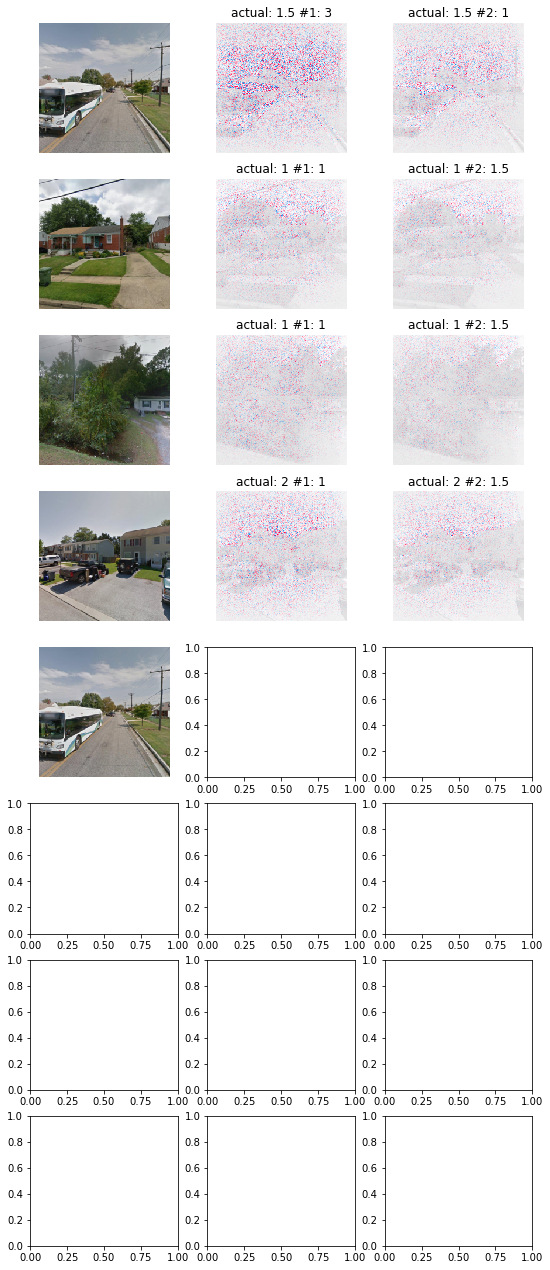

In [0]:
labels = np.array([["actual: " + class_names[classified[i]] + " #1: " + class_names[indexes[i][0]], "actual: " + class_names[classified[i]] + " #2: " + class_names[indexes[i][1]]] for i in range(4)])
shap.image_plot(shap_numpy, np.array(images), labels=labels, show=True)

In [0]:
indexes

tensor([[4, 0],
        [0, 1],
        [0, 1],
        [0, 1]], device='cuda:0')

In [1]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import numpy as np
import json
import shap

# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True)
X,y = shap.datasets.imagenet50()
to_explain = X[[39,41]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)

ModuleNotFoundError: No module named 'keras'